# Lab 5: Spam Detection

**Deadline**: Monday, March 15, 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gautam Dawar <gautam.dawar@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/APS360_Labs/LAB_5/Lab_5_Spam_Detection.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/APS360_Labs/LAB_5/Lab_5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 442396 bytes to /content/drive/MyDrive/APS360_Labs/LAB_5/Lab_5_Spam_Detection.html


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1eCAyqmPKbHijR-T3OXRo8S_5DESfZYr7/view?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
data_nonspam = []
data_spam = []
for line in open('SMSSpamCollection'):
    if line[0] == 'h':
      data_nonspam.append(line)
    if line[0] == 's':
      data_spam.append(line)
      
print('Example of non-spam SMS:\n', data_nonspam[0])
print('Example of spam SMS:\n', data_spam[0])

Example of non-spam SMS:
 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Example of spam SMS:
 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



Label value for a non-spam message is 'ham' while for a spam message the label is 'spam'.



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
print('Number of non spam messages:', len(data_nonspam))
print('Number of spam messages:', len(data_spam))

Number of non spam messages: 4827
Number of spam messages: 747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:

*  Mispelled words will not affect the model. Also likelihood of seeing an unknown character is significantly lower than seeing an unkown word
*  Since there are way less characters than words, the memory required to store the tokens is less

Disadvantages:

*  Lower accuracy results than word based because characters do not carry meaning while words do.
*  Higher computational cost for training the networks since all message contains more characters than words, the input to the RNN will be much longer

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])
print('Length of train dataset: ', len(train))
print('Length of validation dataset: ', len(valid))
print('Length of test dataset: ', len(test))

Length of train dataset:  3343
Length of validation dataset:  1115
Length of test dataset:  1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

If the training dataset is imbalanced towards one partiular label, the model will bias itself to predict that specific label which is not representative towards a more general case. The model will be able to achieve an very high training accuracy just by predicting every datapoint is non-spam but then running this trained model on the test dataset we will see how many false negative misclassification errors there are. Therefore, we need to balance the training dataset in order for te model to correctly classify both spam and non spam messages and achieve a good training performance.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
# text_field.vocab.stoi: A collections.defaultdict instance mapping token strings to numerical identifiers.
# text_field.vocab.itos: A list of token strings indexed by their numerical identifiers.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk>: a character that in unkown, doent't exist in the vocabulary
# <pad>: special token used to increse the messages size in order to have all SMS of the same length in a batch 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs                                           

In [ ]:
i=0 # keep track of the number of iterations
maxLength = np.zeros(10, dtype=int)
padCount = np.zeros(10, dtype=int)

for batch in train_iter:
    if i < 10:
      for sms in batch.sms[0]:
        #Step one: check if size of this message is bigger than the current max
        if len(sms) > maxLength[i]:
          maxLength[i]=len(sms)
        #Step two: count the number of pads
        for token in sms:
          if token == text_field.vocab.stoi["<pad>"]:
            padCount[i] +=1
    else:
      break
    i+=1
    
print('Array with the maximum length of input sequence in each batch: ', maxLength)
print('Number of pad tokens used in each batch: ', padCount)

Array with the maximum length of input sequence in each batch:  [ 24  55 158 137 153 144 150  52 133  68]
Number of pad tokens used in each batch:  [28 44 23 17  0 23 11 15 51 51]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, hidden_size, n_layers=1):
    super(RNN, self).__init__()
    self.name="spam_detector"
    self.ident = torch.eye(vocab_size)
    self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)
    self.classifier = nn.Linear(hidden_size, 2) 

  def forward(self, x):
    one_hot = []
    for sms in x:
      one_hot.append(self.ident[sms])   
    inp_x = torch.stack(one_hot)
    output, _ = self.rnn(inp_x)           
    out =  torch.max(output, dim=1)[0]    
    out = self.classifier(out)         
    return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    Example usage:
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def train_rnn_network(model, train, valid, num_epochs, learning_rate=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_loss, valid_loss, train_acc, valid_acc = [], [], [], []
    epochs = []
    
    for epoch in range(num_epochs):
        avg_loss = 0
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        
        train_loss.append(float(loss))
        epochs.append(epoch+1)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        # save model
        model_path = f"model_{model.name}_lr{learning_rate}_epoch{epoch}"
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Loss curves")
    plt.plot(train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accurcy curves")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Final results
    print("Final Train Accuracy:", train_acc[-1])
    print("Final Valid Accuracy:", valid_acc[-1])

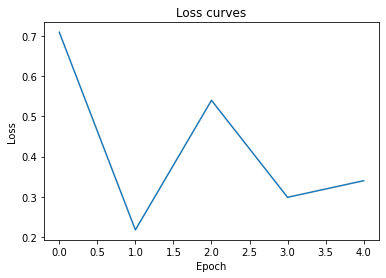

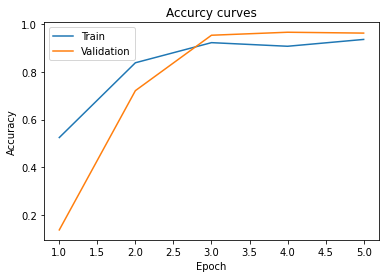

Final Train Accuracy: 0.9357813271859048
Final Valid Accuracy: 0.9623318385650225


In [ ]:
net = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
train_rnn_network(net, train_iter, valid_iter, num_epochs=5, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Chosen hyperparameters to be tuned: 
* number of epochs
* learning rate
* number of layers in the GRU layer 
* input to the fully connected layer (train_iter instead of train)

Here are the tests I have made in order to properly tune the above mentioned parameters:
1.  Number of layers 
in the GRU increased to 2 and number of epochs doubled (10). Overall performance is excellent and the model does not overfit, indeed validation accuracy is very high.

Results: Loss ~ 0.085 -
Final Train Accuracy: 0.967385 -
Final Validation Accuracy: 0.963838

2.  Architecture changed by using a concatenation of the max pooling and average pooling of the GRU output as the input to the fully connected layer. Everything else is kept same. Training accuracy is slightly better but lower validation accuracy makes me suspect of slightly overfit.

Results: Loss ~ 0.075 - 
Final Train Accuracy 0.962075 - 
Final Validation Accuracy 0.949776

3. Everything kept as (2) except learning rate increased to 5e-4 in order to try avoiding local minima. Results achieved are so far the best, however model converges after about 5 epochs and then it overfits.

Results: Loss ~0.090 - 
Final Train Accuracy 0.985098 - 
Final Validation Accuracy 0.980124

4. Everything kept as (3) except epochs number that has been lowered back to 5.
This is the model I chose to keep since achieves the best performance without risk of overfitting.

Results: Loss ~0.070 - 
Final Train Accuracy 0.979252 - 
Final Validation Accuracy 0.984753


In [ ]:
class new_RNN(nn.Module):
  def __init__(self, vocab_size, hidden_size, n_layers=1):
    super(new_RNN, self).__init__()
    self.name="new_spam_detector"
    self.ident = torch.eye(vocab_size)
    self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)
    self.classifier = nn.Linear(2*hidden_size, 2)  # change made here

  def forward(self, x):
    one_hot = []
    for sms in x:
      one_hot.append(self.ident[sms])   
    inp_x = torch.stack(one_hot)
    output, _ = self.rnn(inp_x)          
    out = torch.cat([torch.max(output, dim=1)[0], torch.mean(output, dim=1)], dim=1)     # concatenate the max pooling and avg pooling of the GRU output
    out = self.classifier(out)          
    return out

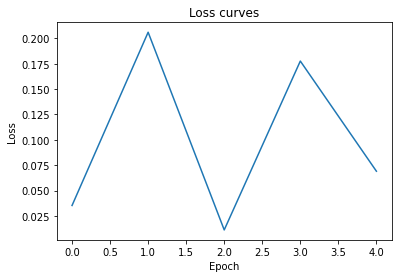

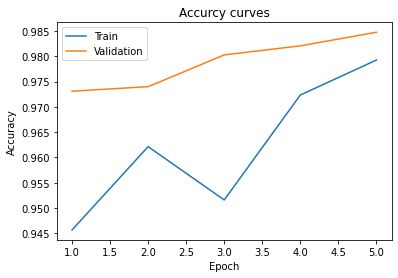

Final Train Accuracy: 0.9792524287831385
Final Valid Accuracy: 0.9847533632286996


In [ ]:
new_net = new_RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2)
train_rnn_network(new_net, train_iter, valid_iter, num_epochs=5, learning_rate=5e-4)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam, batch_size=32,
               sort_key=lambda x: len(x.sms), # to minimize padding
               sort_within_batch=True,        # sort within each batch
               repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                batch_size=32,
                sort_key=lambda x: len(x.sms), # to minimize padding
                sort_within_batch=True,        # sort within each batch
                repeat=False)                  # repeat the iterator for many epochs

final_model = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2)

In [ ]:
false_pos = 1 - get_accuracy(final_model, valid_nospam_iter)
false_neg = 1 - get_accuracy(final_model, valid_spam_iter)
print("The model's false positive rate is ", false_pos)
print("The model's false negative rate is ", false_neg)

The model's false positive rate is 0.017638330977327508
The model's false negative rate is 0.055739308594058707


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false positive means that a message is detected as spam when in reality it a valid message. Blocking on your phone a message that was not spam can have a high impact since it could contain iportant information needed by the phone user.

A false negative instead, means that a spam message was detected a good message and therefore gets not blocked. This can be annoying for the phone user becuase he/she needs to manually delete it but this case is not as impactful as having a false positive and risking of missing an important message.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_acc = get_accuracy(final_model, test_iter)
print('Final test accuracy: ', test_acc)

Final test accuracy:  0.8752244165170556


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1], test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam, batch_size=32,
               sort_key=lambda x: len(x.sms), # to minimize padding
               sort_within_batch=True,        # sort within each batch
               repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0], test.fields)

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                batch_size=32,
                sort_key=lambda x: len(x.sms), # to minimize padding
                sort_within_batch=True,        # sort within each batch
                repeat=False)                  # repeat the iterator for many epochs

In [ ]:
test_false_pos = 1 - get_accuracy(final_model, test_nospam_iter)
test_false_neg = 1 - get_accuracy(final_model, test_spam_iter)
print("The model's false positive rate is ", test_false_pos)
print("The model's false negative rate is ", test_false_neg)

The model's false positive rate is 0.036749068069406870
The model's false negative rate is 0.098396064869708057


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
msg_tokens = []
for char in msg:
  msg_tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(msg_tokens)
x.unsqueeze_(0)
prediction = F.softmax(final_model(x), dim=1)[0][1].item()
print("Probability of spam SMS message:", prediction)

Probability of spam SMS message: 0.49640509486198425


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Since the field of spam fetection as been studied already for several years and big companies as Google, Microsoft and Apple have implemented and tested advanced spam blocking engines (using several different methods such as neural networks, Naive Bayes Classifiers and heuristics and word based filters etc...) I would say this problem has now become easy to solve. of course it still remain a complex problem but all these recent advancements in  machine learning have made it easier to tackle.

From personal experience, the spam messages that i receive typically contain a lot of special charaters and very long sequnces of letters and numbers that do not have any meaning. A very easy baseline model based on this known fact could be outlined by the following pseudo code:



In [ ]:
# a message is classified as spam if it contains a word like:
# jh478hf32gb39u012fhuvg5439fafbsksc or @#$^**&*^*???!!!@%&*$^&(%3)
def baseline_model(input_message): 
    if ((len(word) > 30 && word has char+numbers) || number of continuous special chars > 10): 
      return 1 #output if message is detected to be spam
    else;
      return 0 # output if message is detected to be non-spam

input = get message 
prediction = baseline(input) 

if (prediction == 1):
  block input
